# Install depandables Geemap and *(google earth engine when using the jupyter notebook)

In [ ]:
!pip install geemap
!pip install earthengine-api

#**GPS** **1** -**TEMPERATURE** **FORECASTING** - **CNN**-**LSTM** **ON** **GPS** **1** **GPS 1(EGERTON)**

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import ee
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, TimeDistributed
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [5]:
#Authenticate and Initialize the google api
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AVHEtk6wZeHUcSXx8mD_q2RTOBNwHrp2javHU6FSDR-HKRlKZ_f21JYEFUU

Successfully saved authorization token.


In [96]:

# Define the latitude and longitude of the point
lat = 35.3357
lon = -0.7778

# Create a point geometry
point = ee.Geometry.Point(lon, lat)
#CNN-LSTM
#Define the number of years of data to use for training
train_years = 12

#Define the number of days of data to use for each time step
time_steps = 365

#Define the number of time steps to uses for each training sequence
sequence_length = 30

# Define the number of filters and kernel size for the CNN layer
num_filters = 64
kernel_size = 3

# Define the number of LSTM units for the LSTM layer
num_lstm_units = 64

# Define the number of epochs and batch size for training
num_epochs = 30
batch_size = 32

# Define the time range for the data
start_date = ee.Date('2004-01-01')
end_date = ee.Date('2020-12-31')

# Retrieve temperature data from Earth Engine
temp_collection = ee.ImageCollection('MODIS/061/MOD11A1') \
    .select('LST_Day_1km')\
    .filterDate(start_date, end_date)
    
#Reduce the image collection to a single image at the given loacation and time
temp_image = temp_collection.filterBounds(point)

# Extract thetemperature value at the give region
temp_data = temp_image.getRegion(point, scale =0.02).getInfo()

#Convert the data into a dataframe
columns = ['time', 'latitude', 'longitude','quality','temperature']
temp_df = pd.DataFrame(temp_data[1:], columns=columns)
temp_df.set_index('time', inplace = True)

#Convert temperature column to float and replace missing values with NaN
temp_df['temperature'] = pd.to_numeric(temp_df['temperature'], errors='coerce')

# Convert the index to a datetime object
temp_df.index = pd.to_datetime(temp_df.index, format='%Y_%m_%d')

# Resample the data to daily frequency
temp_df_daily = temp_df.resample('D').mean()


In [97]:
temp_df_daily

,latitude,longitude,quality,temperature
time,,,,
2004-01-01,-0.7778,35.3357,1.072915e+12,NaN
2004-01-02,-0.7778,35.3357,1.073002e+12,NaN
2004-01-03,-0.7778,35.3357,1.073088e+12,14196.0
2004-01-04,-0.7778,35.3357,1.073174e+12,14350.0
2004-01-05,-0.7778,35.3357,1.073261e+12,NaN
...,...,...,...,...
2020-12-26,-0.7778,35.3357,1.608941e+12,14270.0
2020-12-27,-0.7778,35.3357,1.609027e+12,14349.0
2020-12-28,-0.7778,35.3357,1.609114e+12,NaN


In [98]:
#Check for missing or nan values
print(temp_df_daily['temperature'].isnull().sum()) # number of missing values
print(np.isinf(temp_df_daily['temperature']).sum()) # number of infinite values


2643
0


In [99]:
# Perform local imputation on the temperature column using forward and backward filling
temp_df_daily['temperature_diff']= temp_df_daily['temperature'].fillna(method='ffill').fillna(method='bfill')

In [100]:
#Check for missing or nan values
print(temp_df_daily['temperature_diff'].isnull().sum()) # number of missing values
print(np.isinf(temp_df_daily['temperature_diff']).sum()) # number of infinite values

0
0


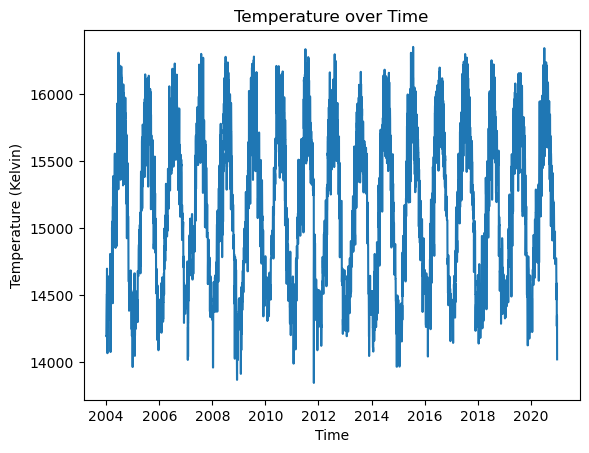

In [101]:
# Visualize the dataset
plt.plot(temp_df_daily.index,temp_df_daily['temperature_diff'])
plt.title('Temperature over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (Kelvin)')
plt.show()


In [102]:
# Define the input and output variables for the model
X = []
y = []

# Iterate over each sequence in the dataset
for i in range(len(temp_df_daily['temperature_diff']) - sequence_length - 1):
    # Extract a sequence of temperature values
    seq_temp = temp_df_daily['temperature_diff'].values[i:i+sequence_length]
    # Define the target temperature value
    target_temp = temp_df_daily['temperature_diff'].values[i+sequence_length]
    
    # Append the sequence and target values to the input and output lists
    X.append(seq_temp)
    y.append(target_temp)
    
# Convert the input and output lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [103]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2,random_state=0)

print('Train set', X_train.shape)
print('Test set', X_test.shape)
    

Train set (4942, 30)
Test set (1236, 30)


In [125]:
subsequences=2
timesteps = X_train.shape[1]//subsequences
X_train_sub=X_train.reshape((X_train.shape[0], subsequences, timesteps,1))
X_test_sub=X_test.reshape((X_test.shape[0], subsequences, timesteps,1))
y_train_sub=y_train.reshape(y_train.shape[0],1)
y_test_sub =y_test.reshape(y_test.shape[0],1)

print('Train set shape', X_train_sub.shape)
print('Test set shape', X_test_sub.shape)

Train set shape (4942, 2, 15, 1)
Test set shape (1236, 2, 15, 1)


In [127]:
X_train_sub

array([[[[0.6293344 ],
         [0.6316    ],
         [0.53686728],
         ...,
         [0.7744    ],
         [0.62349155],
         [0.75368673]],

        [[0.75368673],
         [0.75140788],
         [0.5583898 ],
         ...,
         [0.59613837],
         [0.69549621],
         [0.79155042]]],


       [[[0.36548426],
         [0.3668    ],
         [0.36628139],
         ...,
         [0.3892    ],
         [0.38213998],
         [0.4691112 ]],

        [[0.50019928],
         [0.56596943],
         [0.56994819],
         ...,
         [0.6001609 ],
         [0.52092467],
         [0.65803109]]],


       [[[0.82184137],
         [0.7228    ],
         [0.86966919],
         ...,
         [0.742     ],
         [0.68141593],
         [0.75687525]],

        [[0.74053408],
         [0.78881738],
         [0.64208848],
         ...,
         [0.59493162],
         [0.74770825],
         [0.74770825]]],


       ...,


       [[[0.80510163],
         [0.684     ],
         [

In [143]:
# Define the CNN-LSTM model
model = Sequential()

# Add the CNN layers
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,X_train_sub.shape[2], X_train_sub.shape[3]), batch_size=batch_size))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

# Add the LSTM layer
model.add(LSTM(units=50, activation='relu'))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'], )

#Summary of the model
print(model.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (32, None, 13, 64)       256       
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (32, None, 6, 64)        0         
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (32, None, 384)          0         
 stributed)                                                      
                                                                 
 lstm_20 (LSTM)              (32, 50)                  87000     
                                                                 
 dense_20 (Dense)            (32, 1)                   51        
                                                     

In [155]:
# Train the model
cnn_lstm=model.fit(X_train_sub, y_train_sub, validation_data=(X_test_sub, y_test_sub), epochs=num_epochs,verbose=1)

Epoch 1/30
155/155 [==============================] - 1s 9ms/step - loss: 90320.8906 - accuracy: 0.0000e+00 - val_loss: 90377.1094 - val_accuracy: 0.0000e+00
Epoch 2/30
155/155 [==============================] - 2s 10ms/step - loss: 87538.4766 - accuracy: 0.0000e+00 - val_loss: 95754.5859 - val_accuracy: 0.0000e+00
Epoch 3/30
155/155 [==============================] - 2s 12ms/step - loss: 87906.9297 - accuracy: 0.0000e+00 - val_loss: 89489.5547 - val_accuracy: 0.0000e+00
Epoch 4/30
155/155 [==============================] - 2s 10ms/step - loss: 87012.6406 - accuracy: 0.0000e+00 - val_loss: 101208.6172 - val_accuracy: 0.0000e+00
Epoch 5/30
155/155 [==============================] - 2s 11ms/step - loss: 87796.2734 - accuracy: 0.0000e+00 - val_loss: 89490.0703 - val_accuracy: 0.0000e+00
Epoch 6/30
155/155 [==============================] - 2s 10ms/step - loss: 88189.4453 - accuracy: 0.0000e+00 - val_loss: 114135.0703 - val_accuracy: 0.0000e+00
Epoch 7/30
155/155 [=========================

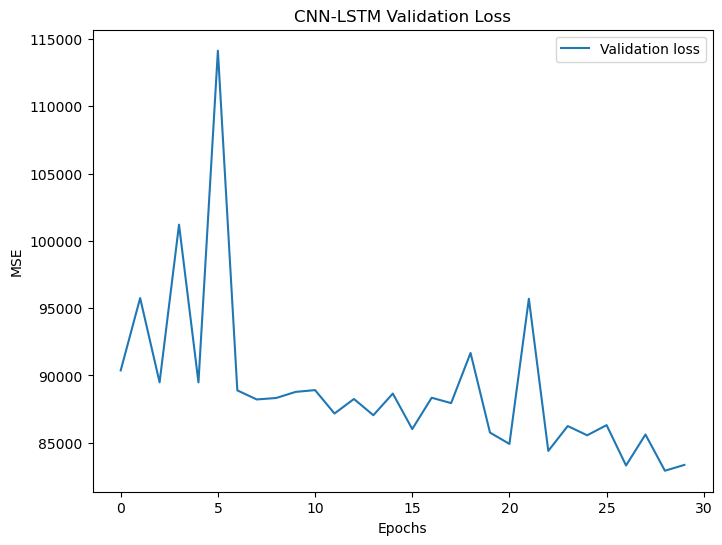

In [156]:

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(cnn_lstm.history['val_loss'], label='Validation loss')
ax.legend(loc='best')
ax.set_title('CNN-LSTM Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()

In [157]:
# Compute the evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Make predictions on the test set
y_pred = model.predict(X_test_sub,)
# Evaluate the model
mse = model.evaluate(X_test_sub, y_test_sub, verbose=1)
print('Mean Squared Error:', mse)
# Compute the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_sub, y_pred))

# Compute the mean squared error (MSE)
mse = mean_squared_error(y_test_sub, y_pred)

# Compute the mean absolute error (MAE)
mae = mean_absolute_error(y_test_sub, y_pred)

print('RMSE:', rmse)
print('MSE:', mse)
print('MAE:', mae)

39/39 [==============================] - 0s 3ms/step - loss: 83354.0156 - accuracy: 0.0000e+00
Mean Squared Error: [83354.015625, 0.0]
RMSE: 288.71091430927
MSE: 83353.99204129462
MAE: 228.31362826152912


In [158]:
#Make predictions on the test set
y_pred = model.predict(X_test_sub)
print(y_pred)

39/39 [==============================] - 0s 3ms/step
[[14723.271]
 [15485.268]
 [15171.908]
 ...
 [14468.825]
 [15722.741]
 [14383.624]]


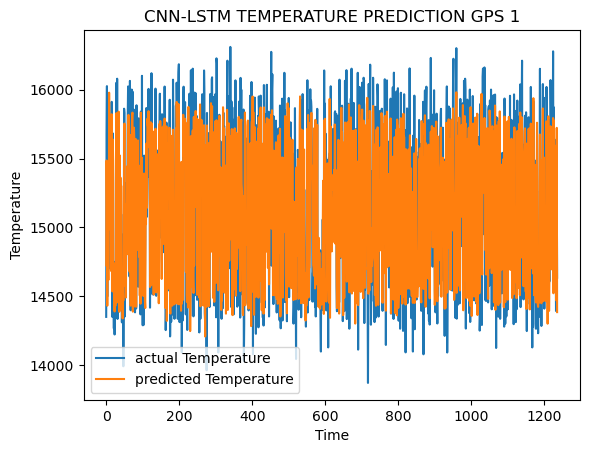

In [159]:
#Plot the comparison between actual temperature and predicted temperature
import matplotlib.pyplot as plt

plt.plot(y_test_sub, label='actual Temperature')
plt.plot(y_pred, label='predicted Temperature')
plt.title('CNN-LSTM TEMPERATURE PREDICTION GPS 1')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# **GPS 1 - PRECIPTATION - CNN-LSTM FOR GPS 1(EGERTON)**

In [11]:
# Define the latitude and longitude of the point
lat = 24.3357
lon = -0.7778

# Create a point geometry
point = ee.Geometry.Point(lon, lat)
#CNN-LSTM
#Define the number of years of data to use for training
train_years = 12

#Define the number of days of data to use for each time step
time_steps = 30

#Define the number of time steps to uses for each training sequence
sequence_length = 30

# Define the number of filters and kernel size for the CNN layer
num_filters = 64
kernel_size = 3

# Define the number of LSTM units for the LSTM layer
num_lstm_units = 128

# Define the number of epochs and batch size for training
num_epochs = 100
batch_size = 32

# Define the time range for the data
start_date = ee.Date('2004-01-01')
end_date = ee.Date('2020-12-31')

# Filter the image collection
precip = ee.ImageCollection('NASA/GPM_L3/IMERG_MONTHLY_V06')

# Filter the image collection by date and select the 'precipitationCal' band
daily_precip = precip.filterDate(start_date, end_date)\
                    .select('precipitation')                    
#Reduce the image collection to a single image at the given loacation and time
precip_image = daily_precip.filterBounds(point)

# Extract the precipitation value at the give region
precip_data = precip_image.getRegion(point, scale = 0.1).getInfo()

#Convert the data into a dataframe
columns = ['time', 'latitude', 'longitude','quality','precipitation']
precip_df = pd.DataFrame(precip_data[1:], columns=columns)
precip_df.set_index('time', inplace = True)

# Convert the index to  datetime object
precip_df.index = pd.to_datetime(precip_df.index, format='%Y%m%d%H%M%S')

# Resample the data to daily frequency
precip_df_daily = precip_df.resample('M').mean()


In [15]:
precip_df_daily

,latitude,longitude,quality,precipitation
time,,,,
2004-01-31,-0.7778,24.3357,1.072915e+12,0.000927
2004-02-29,-0.7778,24.3357,1.075594e+12,0.001281
2004-03-31,-0.7778,24.3357,1.078099e+12,0.002330
2004-04-30,-0.7778,24.3357,1.080778e+12,0.019397
2004-05-31,-0.7778,24.3357,1.083370e+12,0.000499
...,...,...,...,...
2020-08-31,-0.7778,24.3357,1.596240e+12,0.002140
2020-09-30,-0.7778,24.3357,1.598918e+12,0.001481
2020-10-31,-0.7778,24.3357,1.601510e+12,0.001496


In [12]:
#Check for missing or nan values
print(precip_df_daily['precipitation'].isnull().sum()) # number of missing values
print(np.isinf(precip_df_daily['precipitation']).sum()) # number of infinite values

0
0


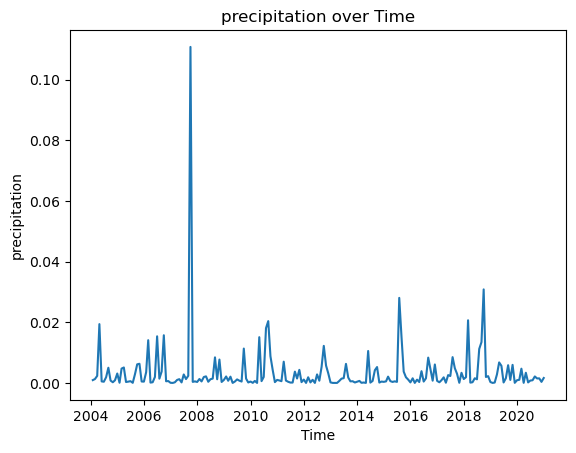

In [13]:
# Visualize the dataset for check of stationarity
plt.plot(precip_df_daily.index,precip_df_daily['precipitation'])
plt.title('precipitation over Time')
plt.xlabel('Time')
plt.ylabel('precipitation')
plt.show()

In [164]:
# Define the input and output variables for the model
X = []
y = []

# Iterate over each sequence in the dataset
for i in range(len(precip_df_daily['precipitation']) - sequence_length - 1):
    # Extract a sequence of temperature values
    seq_temp = precip_df_daily['precipitation'].values[i:i+sequence_length]
    # Define the target temperature value
    target_temp = precip_df_daily['precipitation'].values[i+sequence_length]
    
    # Append the sequence and target values to the input and output lists
    X.append(seq_temp)
    y.append(target_temp)
    
# Convert the input and output lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [172]:
#Split the dataset
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2 ,random_state=0)

print('Train set', X_train.shape)
print('Test set', X_test.shape)

Train set (138, 30)
Test set (35, 30)


In [173]:
subsequences=2
timesteps = X_train.shape[1]//subsequences
X_train_sub=X_train.reshape((X_train.shape[0], subsequences, timesteps,1))
X_test_sub=X_test.reshape((X_test.shape[0], subsequences, timesteps,1))
#y_train_sub=y_train.reshape(y_train.shape[0],1)
#y_test_sub =y_test.reshape(y_test.shape[0],1)

print('Train set shape', X_train_sub.shape)
print('Test set shape', X_test_sub.shape)

Train set shape (138, 2, 15, 1)
Test set shape (35, 2, 15, 1)


In [20]:
# Normalize the input data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [237]:
# Build the CNN-LSTM model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(None,X_train_sub.shape[2],X_train_sub.shape[3]), batch_size=batch_size)))
model.add(TimeDistributed(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(units=num_lstm_units, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')
# Summary of model
print(model.summary())

In [178]:
#Train the model
model.fit(X_train_sub, y_train, validation_data=(X_test_sub, y_test), epochs=num_epochs, batch_size=batch_size)

Epoch 1/100
5/5 [==============================] - 4s 157ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 2/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 3/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 4/100
5/5 [==============================] - 0s 25ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 5/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 6/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 7/100
5/5 [==============================] - 0s 21ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/100
5/5 [==============================] - 0s 26ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 11/100
5/5 [

Epoch 82/100
5/5 [==============================] - 0s 28ms/step - loss: 2.5863e-05 - val_loss: 0.0027
Epoch 83/100
5/5 [==============================] - 0s 33ms/step - loss: 2.5166e-05 - val_loss: 0.0028
Epoch 84/100
5/5 [==============================] - 0s 36ms/step - loss: 4.4137e-05 - val_loss: 0.0027
Epoch 85/100
5/5 [==============================] - 0s 50ms/step - loss: 3.0648e-05 - val_loss: 0.0027
Epoch 86/100
5/5 [==============================] - 0s 34ms/step - loss: 3.0095e-05 - val_loss: 0.0026
Epoch 87/100
5/5 [==============================] - 0s 56ms/step - loss: 2.6748e-05 - val_loss: 0.0028
Epoch 88/100
5/5 [==============================] - 0s 32ms/step - loss: 2.0174e-05 - val_loss: 0.0028
Epoch 89/100
5/5 [==============================] - 0s 38ms/step - loss: 1.5373e-05 - val_loss: 0.0028
Epoch 90/100
5/5 [==============================] - 0s 20ms/step - loss: 1.7127e-05 - val_loss: 0.0027
Epoch 91/100
5/5 [==============================] - 0s 29ms/step - loss: 

In [179]:
# Compute the evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Make predictions on the test set
y_pred = model.predict(X_test_sub)
# Evaluate the model
mse = model.evaluate(X_test_sub, y_test, verbose=1)
print('Mean Squared Error:', mse)
# Compute the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Compute the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Compute the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print('RMSE:', rmse)
print('MSE:', mse)
print('MAE:', mae)

2/2 [==============================] - 0s 11ms/step - loss: 0.0027
Mean Squared Error: 0.002741597592830658
RMSE: 0.05236026773663483
MSE: 0.0027415976374520826
MAE: 0.03872406461741775


In [181]:
#Make predictions on the test set
y_pred = model.predict(X_test_sub)
print(y_pred)

2/2 [==============================] - 0s 12ms/step
[[ 3.0708145e-02]
 [ 2.9858939e-02]
 [ 1.0768043e-01]
 [ 2.7503796e-02]
 [ 7.2270043e-02]
 [ 4.3902855e-02]
 [ 1.1125755e-01]
 [ 1.4035796e-02]
 [ 3.3175834e-02]
 [ 9.4518766e-02]
 [ 1.6622838e-01]
 [-5.2520903e-03]
 [ 3.7206750e-02]
 [ 3.0610509e-02]
 [ 3.5120215e-02]
 [ 9.6143775e-02]
 [ 4.9032129e-02]
 [ 3.2841455e-02]
 [ 3.7296480e-03]
 [ 5.5076405e-02]
 [ 6.4839266e-02]
 [ 3.7626367e-02]
 [ 2.8606027e-02]
 [ 1.7546181e-02]
 [-2.5320370e-03]
 [ 1.0566693e-04]
 [ 9.2656329e-02]
 [ 1.2837519e-01]
 [ 6.3520744e-02]
 [ 1.5063307e-01]
 [ 2.9245816e-02]
 [ 7.1340375e-02]
 [ 2.7943403e-02]
 [ 5.6924753e-02]
 [ 1.0306692e-01]]


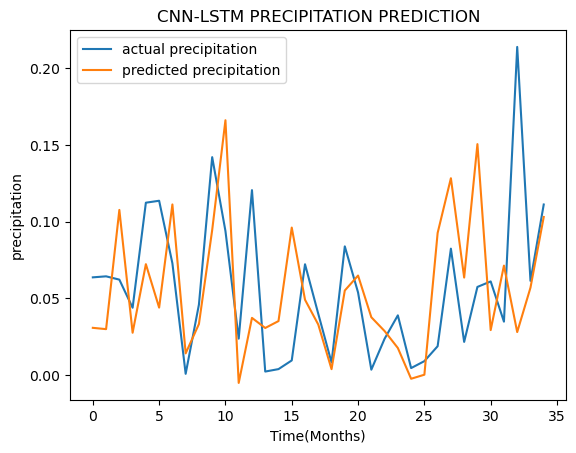

In [182]:
#Plot the comparison between actual temperature and predicted temperature
import matplotlib.pyplot as plt

plt.plot(y_test, label='actual precipitation')
plt.plot(y_pred, label='predicted precipitation')
plt.title('CNN-LSTM PRECIPITATION PREDICTION')
plt.xlabel('Time(Months)')
plt.ylabel('precipitation')
plt.legend()
plt.show()

# GPS 2 - TEMPERATURE FORECAST - CNN-LSTM - GPS 2(PEGG)

In [183]:
# Define the latitude and longitude of the point
lat = 35.0636
lon = -1.3557

# Create a point geometry
point2 = ee.Geometry.Point(lon, lat)

#CNN-LSTM
#Define the number of years of data to use for training
train_years = 12

#Define the number of days of data to use for each time step
time_steps = 365

#Define the number of time steps to uses for each training sequence
sequence_length = 30

# Define the number of filters and kernel size for the CNN layer
num_filters = 256
kernel_size = 3

# Define the number of LSTM units for the LSTM layer
num_lstm_units = 64

# Define the number of epochs and batch size for training
num_epochs = 100
batch_size = 32

# Define the time range for the data
start_date = ee.Date('2004-01-01')
end_date = ee.Date('2020-12-31')

# Retrieve temperature data from Earth Engine
temp_collection = ee.ImageCollection('MODIS/061/MOD11A1') \
    .select('LST_Day_1km')\
    .filterDate(start_date, end_date)
    
#Reduce the image collection to a single image at the given loacation and time
temp_image = temp_collection.filterBounds(point2)

# Extract thetemperature value at the give region
temp_data = temp_image.getRegion(point, scale = 0.02).getInfo()

#Convert the data into a dataframe
columns = ['time', 'latitude', 'longitude','quality','temperature']
temp_df = pd.DataFrame(temp_data[1:], columns=columns)
temp_df.set_index('time', inplace = True)

#Convert temperature column to float and replace missing values with NaN
temp_df['temperature'] = pd.to_numeric(temp_df['temperature'], errors='coerce')

# Convert the index to a datetime object
temp_df.index = pd.to_datetime(temp_df.index, format='%Y_%m_%d')

# Resample the data to daily frequency
temp_df_daily = temp_df.resample('D').mean()

# Apply a logarithmic transformation to the temperature data
temp_df_daily['temperature_log'] = np.log(temp_df_daily['temperature'])


In [184]:
#Check for missing or nan values
print(temp_df_daily['temperature'].isnull().sum()) # number of missing values
print(np.isinf(temp_df_daily['temperature']).sum()) # number of infinite values

2643
0


In [185]:
# Perform local imputation on the temperature column using forward and backward filling
temp_df_daily['temperature_diff']= temp_df_daily['temperature'].fillna(method='ffill').fillna(method='bfill')

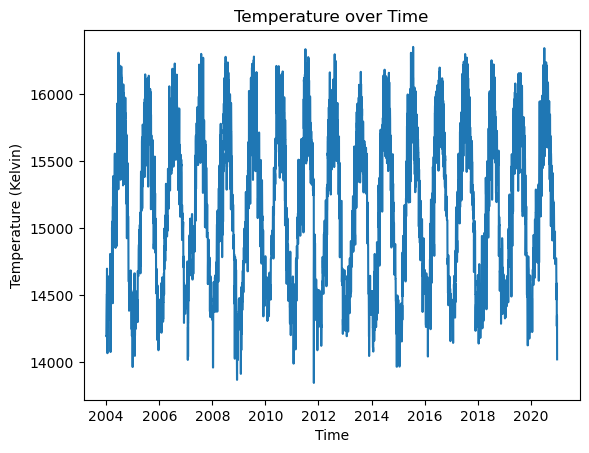

In [186]:
# Visualize the dataset
plt.plot(temp_df_daily.index,temp_df_daily['temperature_diff'])
plt.title('Temperature over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (Kelvin)')
plt.show()


In [187]:
# Define the input and output variables for the model
X = []
y = []

# Iterate over each sequence in the dataset
for i in range(len(temp_df_daily['temperature_diff']) - sequence_length - 1):
    # Extract a sequence of temperature values
    seq_temp = temp_df_daily['temperature_diff'].values[i:i+sequence_length]
    # Define the target temperature value
    target_temp = temp_df_daily['temperature_diff'].values[i+sequence_length]
    
    # Append the sequence and target values to the input and output lists
    X.append(seq_temp)
    y.append(target_temp)
    
# Convert the input and output lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [188]:
#Split the dataset
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2 ,random_state=0)

print('Train set', X_train.shape)
print('Test set', X_test.shape)

Train set (4942, 30)
Test set (1236, 30)


In [189]:
#Subset the dataset
subsequences=2
timesteps = X_train.shape[1]//subsequences
X_train_sub=X_train.reshape((X_train.shape[0], subsequences, timesteps,1))
X_test_sub=X_test.reshape((X_test.shape[0], subsequences, timesteps,1))
#y_train_sub=y_train.reshape(y_train.shape[0],1)
#y_test_sub =y_test.reshape(y_test.shape[0],1)

print('Train set shape', X_train_sub.shape)
print('Test set shape', X_test_sub.shape)

Train set shape (4942, 2, 15, 1)
Test set shape (1236, 2, 15, 1)


In [77]:
# Normalize the input data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [204]:
# Define the CNN-LSTM model
model = Sequential()

# Add the CNN layers
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,X_train_sub.shape[2], X_train_sub.shape[3]), batch_size=batch_size))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

# Add the LSTM layer
model.add(LSTM(units=50, activation='relu'))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'], )

#Summary of the model
print(model.summary())

# Model Summary
print(model.summary())

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_84 (TimeDi  (32, None, 13, 64)       256       
 stributed)                                                      
                                                                 
 time_distributed_85 (TimeDi  (32, None, 6, 64)        0         
 stributed)                                                      
                                                                 
 time_distributed_86 (TimeDi  (32, None, 384)          0         
 stributed)                                                      
                                                                 
 lstm_32 (LSTM)              (32, 50)                  87000     
                                                                 
 dense_32 (Dense)            (32, 1)                   51        
                                                     

In [205]:
# Train the model
cnn_lstm=model.fit(X_train_sub, y_train, validation_data=(X_test_sub, y_test), epochs=num_epochs, batch_size=batch_size)

Epoch 1/100
155/155 [==============================] - 5s 15ms/step - loss: 13548959.0000 - accuracy: 0.0000e+00 - val_loss: 63409.2617 - val_accuracy: 0.0000e+00
Epoch 2/100
155/155 [==============================] - 2s 11ms/step - loss: 62153.9453 - accuracy: 0.0000e+00 - val_loss: 64935.1719 - val_accuracy: 0.0000e+00
Epoch 3/100
155/155 [==============================] - 2s 12ms/step - loss: 62472.1523 - accuracy: 0.0000e+00 - val_loss: 63207.8711 - val_accuracy: 0.0000e+00
Epoch 4/100
155/155 [==============================] - 1s 9ms/step - loss: 61955.4180 - accuracy: 0.0000e+00 - val_loss: 63694.4922 - val_accuracy: 0.0000e+00
Epoch 5/100
155/155 [==============================] - 2s 13ms/step - loss: 63545.7188 - accuracy: 0.0000e+00 - val_loss: 63194.0391 - val_accuracy: 0.0000e+00
Epoch 6/100
155/155 [==============================] - 2s 13ms/step - loss: 61939.3672 - accuracy: 0.0000e+00 - val_loss: 64430.8945 - val_accuracy: 0.0000e+00
Epoch 7/100
155/155 [=================

In [ ]:

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(cnn_lstm.history['val_loss'], label='Validation loss')
ax.legend(loc='best')
ax.set_title('CNN-LSTM Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()

In [206]:
# Compute the evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Make predictions on the test set
y_pred = model.predict(X_test_sub)
# Evaluate the model
mse = model.evaluate(X_test_sub, y_test, verbose=1)
print('Mean Squared Error:', mse)
# Compute the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Compute the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Compute the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print('RMSE:', rmse)
print('MSE:', mse)
print('MAE:', mae)

39/39 [==============================] - 0s 3ms/step - loss: 47687.7344 - accuracy: 0.0000e+00
Mean Squared Error: [47687.734375, 0.0]
RMSE: 218.3752142166521
MSE: 47687.73418416869
MAE: 176.24965156629247


In [208]:
#Make predictions on the test set
y_pred = model.predict(X_test_sub)
print(y_pred)

39/39 [==============================] - 0s 3ms/step
[[14425.957]
 [15541.67 ]
 [15250.165]
 ...
 [14246.355]
 [15454.596]
 [14512.292]]


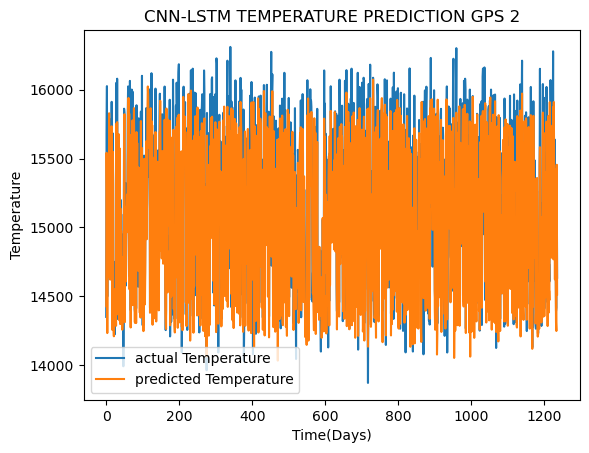

In [209]:
#Plot the comparison between actual temperature and predicted temperature
import matplotlib.pyplot as plt

plt.plot(y_test, label='actual Temperature')
plt.plot(y_pred, label='predicted Temperature')
plt.title('CNN-LSTM TEMPERATURE PREDICTION GPS 2')
plt.xlabel('Time(Days)')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# GPS 2 - PRECIPITATION FORECAST - CNN-LSTM ON GPS 2(PEGG)

In [210]:
# Define the latitude and longitude of the point
lat = 38.0636
lon = -1.3557

# Create a point geometry
point2 = ee.Geometry.Point(lon, lat)

#CNN-LSTM
#Define the number of years of data to use for training
train_years = 12

#Define the number of days of data to use for each time step
time_steps = 365

#Define the number of time steps to uses for each training sequence
sequence_length = 30

# Define the number of filters and kernel size for the CNN layer
num_filters = 64
kernel_size = 3

# Define the number of LSTM units for the LSTM layer
num_lstm_units = 64

# Define the number of epochs and batch size for training
num_epochs = 30
batch_size = 32

# Define the time range for the data
start_date = ee.Date('2004-01-01')
end_date = ee.Date('2008-12-31')

# Filter the image collection
precip = ee.ImageCollection('NASA/GPM_L3/IMERG_MONTHLY_V06')

# Filter the image collection by date and select the 'precipitationCal' band
daily_precip = precip.filterDate(start_date, end_date)\
                    .select('precipitation')                    
#Reduce the image collection to a single image at the given loacation and time
precip_image = daily_precip.filterBounds(point2)

# Extract the precipitation value at the give region
precip_data = precip_image.getRegion(point, scale = 0.01).getInfo()

#Convert the data into a dataframe
columns = ['time', 'latitude', 'longitude','quality','precipitation']
precip_df = pd.DataFrame(precip_data[1:], columns=columns)
precip_df.set_index('time', inplace = True)

# Convert the index to  datetime object
precip_df.index = pd.to_datetime(precip_df.index, format='%Y%m%d%H%M%S')

# Resample the data to daily frequency
precip_df_daily = precip_df.resample('M').mean()

# Apply a logarithmic transformation to the precipitation data
precip_df_daily['precipitation_log'] = np.log(precip_df_daily['precipitation'])

<Axes: xlabel='time'>

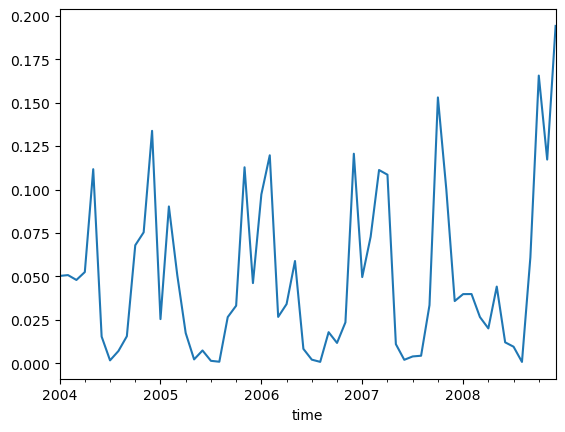

In [211]:
precip_df['precipitation'].plot()

In [212]:
#Check for missing or nan values
print(precip_df_daily['precipitation'].isnull().sum()) # number of missing values
print(np.isinf(precip_df_daily['precipitation']).sum()) # number of infinite values

0
0


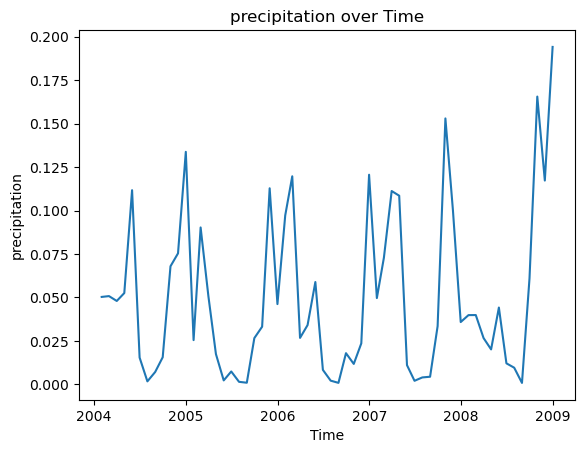

In [213]:
# Visualize the dataset for check of stationarity
plt.plot(precip_df_daily.index,precip_df_daily['precipitation'])
plt.title('precipitation over Time')
plt.xlabel('Time')
plt.ylabel('precipitation')
plt.show()

In [214]:
# Define the input and output variables for the model
X = []
y = []

# Iterate over each sequence in the dataset
for i in range(len(precip_df_daily['precipitation']) - sequence_length - 1):
    # Extract a sequence of temperature values
    seq_temp = precip_df_daily['precipitation'].values[i:i+sequence_length]
    # Define the target temperature value
    target_temp = precip_df_daily['precipitation'].values[i+sequence_length]
    
    # Append the sequence and target values to the input and output lists
    X.append(seq_temp)
    y.append(target_temp)
    
# Convert the input and output lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [215]:
#SPlit the dataset
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2 ,random_state=0)

print('Train set', X_train.shape)
print('Test set', X_test.shape)

Train set (23, 30)
Test set (6, 30)


In [216]:
#Subset the dataset
subsequences=2
timesteps = X_train.shape[1]//subsequences
X_train_sub=X_train.reshape((X_train.shape[0], subsequences, timesteps,1))
X_test_sub=X_test.reshape((X_test.shape[0], subsequences, timesteps,1))
#y_train_sub=y_train.reshape(y_train.shape[0],1)
#y_test_sub =y_test.reshape(y_test.shape[0],1)

print('Train set shape', X_train_sub.shape)
print('Test set shape', X_test_sub.shape)

Train set shape (23, 2, 15, 1)
Test set shape (6, 2, 15, 1)


In [217]:
# Define the CNN-LSTM model
model = Sequential()

# Add the CNN layers
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,X_train_sub.shape[2], X_train_sub.shape[3]), batch_size=batch_size))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

# Add the LSTM layer
model.add(LSTM(units=50, activation='relu'))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'], )

#Summary of the model
print(model.summary())


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_87 (TimeDi  (32, None, 13, 64)       256       
 stributed)                                                      
                                                                 
 time_distributed_88 (TimeDi  (32, None, 6, 64)        0         
 stributed)                                                      
                                                                 
 time_distributed_89 (TimeDi  (32, None, 384)          0         
 stributed)                                                      
                                                                 
 lstm_33 (LSTM)              (32, 50)                  87000     
                                                                 
 dense_33 (Dense)            (32, 1)                   51        
                                                     

In [218]:
#Train the model
cnn_lstm=model.fit(X_train_sub, y_train, validation_data=(X_test_sub, y_test), epochs=num_epochs, batch_size=batch_size)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 0.0056 - accuracy: 0.0000e+00 - val_loss: 8.1293e-05 - val_accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 0s 67ms/step - loss: 0.0048 - accuracy: 0.0000e+00 - val_loss: 1.2602e-04 - val_accuracy: 0.0000e+00
Epoch 3/30
1/1 [==============================] - 0s 58ms/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 2.9092e-04 - val_accuracy: 0.0000e+00
Epoch 4/30
1/1 [==============================] - 0s 59ms/step - loss: 0.0036 - accuracy: 0.0000e+00 - val_loss: 6.0131e-04 - val_accuracy: 0.0000e+00
Epoch 5/30
1/1 [==============================] - 0s 55ms/step - loss: 0.0031 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 6/30
1/1 [==============================] - 0s 67ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 7/30
1/1 [==============================] - 0s 49ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - v

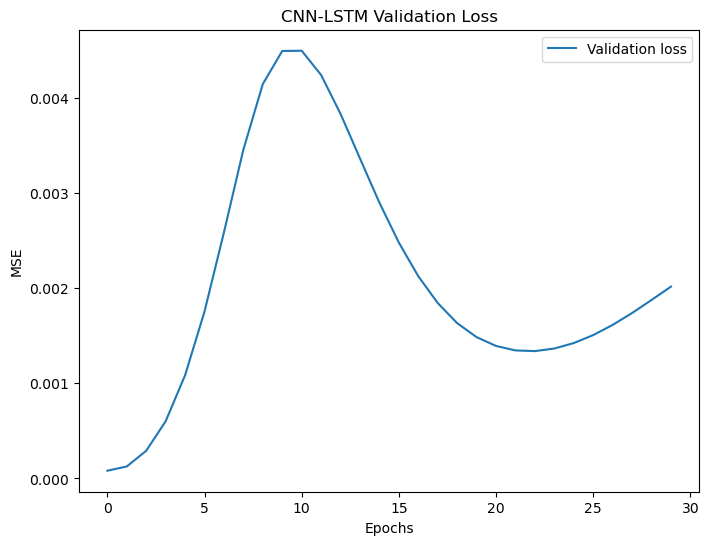

In [219]:

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(cnn_lstm.history['val_loss'], label='Validation loss')
ax.legend(loc='best')
ax.set_title('CNN-LSTM Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()

In [221]:
# Compute the evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Make predictions on the test set
y_pred = model.predict(X_test_sub,)
# Evaluate the model
mse = model.evaluate(X_test_sub, y_test, verbose=1)
print('Mean Squared Error:', mse)
# Compute the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Compute the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Compute the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print('RMSE:', rmse)
print('MSE:', mse)
print('MAE:', mae)

1/1 [==============================] - 0s 44ms/step - loss: 0.0020 - accuracy: 0.0000e+00
Mean Squared Error: [0.002017710590735078, 0.0]
RMSE: 0.04491893050823214
MSE: 0.0020177103180033878
MAE: 0.04456637485418469


In [222]:
#Make predictions on the test set
y_pred = model.predict(X_test_sub)
print(y_pred)

1/1 [==============================] - 0s 45ms/step
[[0.06030352]
 [0.06304449]
 [0.05297226]
 [0.04965732]
 [0.05048847]
 [0.05480615]]


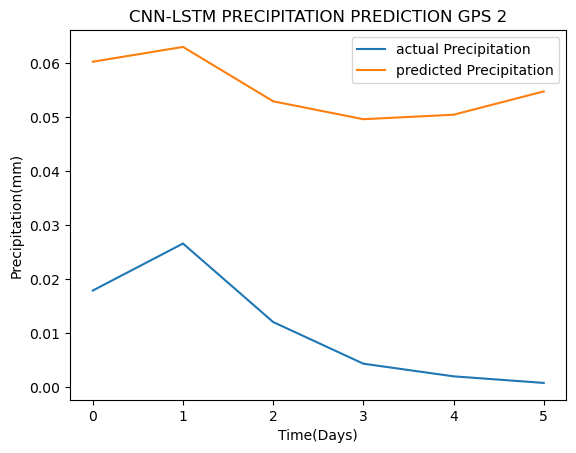

In [223]:
#Plot the comparison between actual temperature and predicted temperature
import matplotlib.pyplot as plt

plt.plot(y_test, label='actual Precipitation')
plt.plot(y_pred, label='predicted Precipitation')
plt.title('CNN-LSTM PRECIPITATION PREDICTION GPS 2')
plt.xlabel('Time(Days)')
plt.ylabel('Precipitation(mm)')
plt.legend()
plt.show()

# NDVI FORECASTING USING THE TEMPERATUIRE AND PRECIPITATION IN GPS 1(EGERTON)

In [6]:
# Load the GeoJSON file
# Define the latitude and longitude of the point
lat = 38.8449
lon = -0.0021

# Create a point geometry
point3 = ee.Geometry.Point(lon, lat)

#CNN-LSTM
#Define the number of years of data to use for training
train_years = 12

#Define the number of days of data to use for each time step
time_steps = 365

#Define the number of time steps to uses for each training sequence
sequence_length = 30

# Define the number of filters and kernel size for the CNN layer
num_filters = 64
kernel_size = 3

# Define the number of LSTM units for the LSTM layer
num_lstm_units = 64

# Define the number of epochs and batch size for training
num_epochs = 30
batch_size = 32

#Extract the Temperature and Precipitation image collection to a single place and time
#define the dates
start_date = ee.Date('2004-1-1')
end_date = ee.Date('2020-12-31')



#TEMPERATURE
TEMP =ee.ImageCollection('MODIS/061/MOD11A1')\
          .filterDate(start_date,end_date)\
          .select('LST_Day_1km')\
          .filterBounds(point3)

#PRECIPITATION
PRECIP = ee.ImageCollection('NASA/GPM_L3/IMERG_MONTHLY_V06')\
          .filterDate(start_date,end_date)\
          .select('precipitation')\
          .filterBounds(point3)


# Extract the temperature value at the give region
TEMP_data = TEMP.getRegion(point3, scale = 0.02).getInfo()

#Convert the data into a dataframe
columns = ['time', 'latitude', 'longitude','quality','temperature']
temp_df = pd.DataFrame(TEMP_data[1:], columns=columns)
temp_df.set_index('time', inplace = True)

#Convert temperature column to float and replace missing values with NaN
temp_df['temperature'] = pd.to_numeric(temp_df['temperature'], errors='coerce')

# Convert the temperature index to a datetime object
temp_df.index = pd.to_datetime(temp_df.index, format='%Y_%m_%d')

# Resample the data to daily frequency
temp_df_daily = temp_df.resample('M').mean()

# Apply a logarithmic transformation to the temperature data
temp_df_daily['temperature_log'] = np.log(temp_df_daily['temperature'])





#Extract the Precipitation value at the give region
PRECIP_data = PRECIP.getRegion(point3, scale = 0.01).getInfo()

#Convert the data into a dataframe
columns = ['time', 'latitude', 'longitude','quality','precipitation']
precip_df = pd.DataFrame(PRECIP_data[1:], columns=columns)
precip_df.set_index('time', inplace = True)

# Convert the precipitation index to  datetime object
precip_df.index = pd.to_datetime(precip_df.index, format='%Y%m%d%H%M%S')

# Resample the data to daily frequency
precip_df_daily = precip_df.resample('M').mean()

# Apply a logarithmic transformation to the precipitation data
precip_df_daily['precipitation_log'] = np.log(precip_df_daily['precipitation'])

In [7]:
#Check for missing or nan values in the precipitation dataset
print(precip_df_daily['precipitation'].isnull().sum()) # number of missing values
print(np.isinf(precip_df_daily['precipitation']).sum()) # number of infinite values


#Check for missing or nan values in the temperature dataset
print(temp_df_daily['temperature'].isnull().sum()) # number of missing values
print(np.isinf(temp_df_daily['temperature']).sum()) # number of infinite values

0
0
0
0


In [8]:
#Perform local imputation on the temperature column using forward and backward filling
temp_df_daily['temperature_diff']= temp_df_daily['temperature'].fillna(method='ffill').fillna(method='bfill')

In [9]:
X = []
y = []

# Iterate over each sequence in the temp_df_daily dataset
for i in range(len(temp_df_daily['temperature_diff']) - sequence_length - 1):
    # Extract a sequence of temperature values
    seq_temp = temp_df_daily['temperature_diff'].values[i:i+sequence_length]
    # Define the target temperature value
    target_temp = temp_df_daily['temperature_diff'].values[i+sequence_length]
    
    # Iterate over each sequence in the precip_df_daily dataset
    for j in range(len(precip_df_daily['precipitation']) - sequence_length - 1):
        # Extract a sequence of precipitation values
        seq_precip = precip_df_daily['precipitation'].values[j:j+sequence_length]
        # Define the target precipitation value
        target_precip = precip_df_daily['precipitation'].values[j+sequence_length]
    
        # Append the sequence and target values to the input and output lists
        X.append([seq_temp,seq_precip])
        y.append([target_temp, target_precip])
    
# Convert the input and output lists to numpy arrays
X = np.array(X)
y = np.array(y)


In [10]:
# Define the number of splits for TimeSeriesSplit
n_splits = 5

# Define the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)

# Iterate over each split and get the training and testing indices
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Assume X_train has shape (n_samples, n_timesteps, n_features)
n_samples, n_timesteps, n_features = X_train.shape
X_train_2d = X_train.reshape(n_samples, n_timesteps * n_features) 
n_samples, n_timesteps, n_features = X_test.shape
X_test_2d = X_test.reshape(n_samples, n_timesteps * n_features)

# Scale the training and testing data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

# Reshape the data for LSTM input
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
y_train_reshaped = y_train_scaled.reshape(y_train_scaled.shape[0], y_train_scaled.shape[1], 1)
y_test_reshaped = y_test_scaled.reshape(y_test_scaled.shape[0], y_test_scaled.shape[1], 1)

In [11]:
# Define the model
model = Sequential()
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
model.add(MaxPooling1D())
model.add(LSTM(num_lstm_units, activation='relu'))
model.add(Dense(2))

# Compile the model
model.compile(optimizer='adam', loss='mse')
# Print the model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 64)            256       
                                                                 
 conv1d_1 (Conv1D)           (None, 56, 64)            12352     
                                                                 
 conv1d_2 (Conv1D)           (None, 54, 64)            12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 52, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                        

In [ ]:
# Fit the model
history = model.fit(X_train_reshaped, y_train_reshaped, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_data=(X_test_reshaped, y_test_reshaped))

Epoch 1/30
780/780 [==============================] - 55s 71ms/step - loss: 0.0127 - val_loss: 0.0071
Epoch 2/30
780/780 [==============================] - 51s 65ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 3/30
780/780 [==============================] - 51s 65ms/step - loss: 5.3852e-04 - val_loss: 0.0019
Epoch 4/30
780/780 [==============================] - 54s 69ms/step - loss: 3.3498e-04 - val_loss: 0.0022
Epoch 5/30
780/780 [==============================] - 40s 51ms/step - loss: 2.1857e-04 - val_loss: 0.0022
Epoch 6/30
780/780 [==============================] - 38s 49ms/step - loss: 2.0392e-04 - val_loss: 0.0023
Epoch 7/30
780/780 [==============================] - 30s 38ms/step - loss: 1.5130e-04 - val_loss: 0.0021
Epoch 8/30
780/780 [==============================] - 31s 39ms/step - loss: 1.1273e-04 - val_loss: 0.0022
Epoch 9/30
780/780 [==============================] - 30s 39ms/step - loss: 1.3999e-04 - val_loss: 0.0021
Epoch 10/30
780/780 [==============================] -

In [233]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Make predictions on the test set
y_pred = model.predict(X_test_reshaped)
# Evaluate the model
mse = model.evaluate(X_test_reshaped, y_test_reshaped, verbose=1)
print('Mean Squared Error:', mse)



156/156 [==============================] - 4s 27ms/step - loss: 0.0021
Mean Squared Error: 0.0020870892331004143


In [234]:
y_pred

array([[0.9269474 , 0.10312179],
       [0.92790693, 0.1766177 ],
       [0.92707354, 0.06018639],
       ...,
       [0.28434715, 0.06814318],
       [0.28606814, 0.03194173],
       [0.28589714, 0.22066094]], dtype=float32)

In [68]:
y_test_reshaped

array([[[0.92724575],
        [0.10313749]],

       [[0.92724575],
        [0.17246448]],

       [[0.92724575],
        [0.05829492]],

       ...,

       [[0.28408963],
        [0.06367204]],

       [[0.28408963],
        [0.0244819 ]],

       [[0.28408963],
        [0.21935477]]])

In [236]:
#Make predictions on the test set
y_pred = model.predict(X_test_reshaped)
print(y_pred)

156/156 [==============================] - 2s 10ms/step
[[0.9269474  0.10312179]
 [0.92790693 0.1766177 ]
 [0.92707354 0.06018639]
 ...
 [0.28434715 0.06814318]
 [0.28606814 0.03194173]
 [0.28589714 0.22066094]]
